### 0. Import libraries

In [17]:
# Torch and Torchlightning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.nn.utils.rnn import pad_sequence

# Import Pytorch modules
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger,CSVLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

from torch.utils.tensorboard import SummaryWriter

# pytorch model summary 
from pytorch_model_summary import summary

# Sklearn for onehote encoding
from sklearn.preprocessing import LabelEncoder

# pandas
import pandas as pd

#Plotting tools 
import matplotlib.pyplot as plt

# some other utility modules
import random
import ast
import os

# Imports for SandiaPV
from pvlib import irradiance, temperature, pvsystem

from sandiapv_energy_prediction import *
import optuna


## 1. Define model

In [18]:
class EnergyPredictionModel(nn.Module):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size, dropout_rate=0.1):
        super(EnergyPredictionModel, self).__init__()
        self.dynamic_rnn1 = nn.LSTM(input_size=dynamic_feature_size, hidden_size=hidden_size, batch_first=True)
        self.dynamic_rnn2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        
        # Increased depth in fully connected layers
        self.fc1 = nn.Linear(hidden_size + static_feature_size, 2*hidden_size)  
        self.fc2 = nn.Linear(2*hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 24)
        
        self.gelu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid() 

        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)
            
    def forward(self, dynamic_features, static_features):
        # Two LSTM layers
        output, _ = self.dynamic_rnn1(dynamic_features)
        output, (h_n, _) = self.dynamic_rnn2(output)
        h_n = h_n.squeeze(0)
        
        concatenated_features = torch.cat((h_n, static_features), dim=1)
        
        x = self.fc1(concatenated_features)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc3(x)

        output =  self.sigmoid(x)
        
        return output

## 2. Define training class


In [19]:
class TrainEnergyPrediction(pl.LightningModule):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size, learning_rate, loss_type='mse'):
        super().__init__()
        self.save_hyperparameters()
        self.model = EnergyPredictionModel(dynamic_feature_size, static_feature_size, hidden_size, dropout_rate=0.1)
        self.tensorboard_logs = SummaryWriter()

        if loss_type == 'mse':
            self.loss_fn = nn.MSELoss(reduction='sum')
        elif loss_type == 'l1':
            self.loss_fn = nn.L1Loss(reduction='sum')
        elif loss_type == 'huber':
            self.loss_fn = nn.HuberLoss(reduction='sum', delta=1.0)
        else:
            raise ValueError("Unsupported loss type. Choose from 'mse', 'l1', 'nll'.")

        self.train_losses = []
        self.validation_losses = []
        self.test_losses = []
        self.learning_rate = learning_rate
        
    def forward(self, x_dynamic, x_static):
        return self.model(x_dynamic, x_static)

    def training_step(self, batch, batch_idx):
        x_dynamic, x_static, y_true = batch
 
        y_pred = self(x_dynamic, x_static)
 
        train_loss = self.loss_fn(y_pred, y_true)
        self.train_losses.append(train_loss.item())
    
        # Calculate AUC for predictions and ground truth
        auc_pred = self.calculate_auc(y_pred)
        auc_gt = self.calculate_auc(y_true)
        auc_ratio = auc_pred / auc_gt if auc_gt != 0 else 0

        # Log metrics   
        self.log('train_auc', auc_ratio, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_loss', train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return train_loss

    def validation_step(self, batch, batch_idx):
        x_dynamic, x_static, y_true = batch
        y_pred = self(x_dynamic, x_static)
        val_loss = self.loss_fn(y_pred, y_true)
        self.validation_losses.append(val_loss.item()) 
        # Calculate AUC for predictions and ground truth
        auc_pred = self.calculate_auc(y_pred)
        auc_gt = self.calculate_auc(y_true)
        auc_ratio = auc_pred / auc_gt if auc_gt != 0 else 0

        # Log metrics
        self.log('validation_auc', auc_ratio, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_loss', val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True) 

        return val_loss
    
    def test_step(self, batch, batch_idx, dataloader_idx=0):
        x_dynamic, x_static, y_true = batch
        y_pred = self(x_dynamic, x_static)
        test_loss = self.loss_fn(y_pred, y_true)
        mean_loss = nn.L1Loss(reduction='mean')(y_pred, y_true)
        
        # Calculate AUC for predictions and ground truth
        auc_pred = self.calculate_auc(y_pred)
        auc_gt = self.calculate_auc(y_true)
        auc_ratio = auc_pred / auc_gt if auc_gt != 0 else 0

        # Log metrics
        self.log(f'Total test_loss', test_loss)
        self.log(f'Total L1 loss', mean_loss)
        self.log(f'Total auc_ratio', auc_ratio)
        self.test_losses.append(test_loss.item())
        
        return {
            'test_loss': test_loss,
            'mean_loss': mean_loss,
            'auc_ratio': auc_ratio,
        }

    def predict(self, x_dynamic, x_static):
        return self.model(x_dynamic, x_static)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer
    
    def calculate_auc(self, y_values):
        y_values = y_values.detach().numpy()
        auc = np.trapz(y_values, axis=1)
        return np.mean(auc)



<style>
div.cell, div.input_area, div.output_area {
    background-color: #f0f0f0; /* Light grey color */
}
</style>

## 3. Load dataset

In [20]:
CONVERTER = {
    'temperature_sequence': ast.literal_eval, 
    'wind_speed_sequence': ast.literal_eval, 
    'dni_sequence': ast.literal_eval, 
    'dhi_sequence': ast.literal_eval, 
    'global_irradiance_sequence': ast.literal_eval,
    'energy_data': ast.literal_eval,
}

class SolarPanelDataset(Dataset):
    def __init__(self, synthetic_csv, measurement_csv, transform=None, sequence_length=24):
        self.sequence_length = sequence_length
        self.mean = []
        self.std =[]
        self.dynamic_cols = ['temperature_sequence', 'wind_speed_sequence', 'dni_sequence', 'dhi_sequence', 'global_irradiance_sequence']
        self.static_cols = ['tilt', 'azimuth' ]   
        self.features = self.dynamic_cols + self.static_cols 
        
        # Load data from both CSVs
        self.synthetic_data = pd.read_csv(synthetic_csv, converters=CONVERTER)  
        self.measurement_data = pd.read_csv(measurement_csv, converters=CONVERTER) 
        
        # Optionally apply transformations/pre-processing
        self.transform = transform
        
        # Combine data for easy shuffling and splitting
        self.synthetic_data['data_type'] = 'synthetic'
        self.measurement_data['data_type'] = 'measurement'
        self.data_frame = pd.concat([self.synthetic_data, self.measurement_data], ignore_index=True)
        
        # Encode string to int
        self.data_frame['module_type'] = LabelEncoder().fit_transform(self.data_frame['module_type'])
        
        # Ensure all sequences are of the same length
        self.pad_or_truncate_sequences()

        self.normalize_features()
        self.normalize_outputs()

    def pad_or_truncate_sequences(self):
        dynamic_cols = ['temperature_sequence', 'wind_speed_sequence', 'dni_sequence', 'dhi_sequence', 'global_irradiance_sequence']
        for col in dynamic_cols:
            self.data_frame[col] = self.data_frame[col].apply(self.pad_or_truncate)

    def pad_or_truncate(self, sequence):
        if len(sequence) > self.sequence_length:
            return sequence[:self.sequence_length]
        elif len(sequence) < self.sequence_length:
            return sequence + [0.0] * (self.sequence_length - len(sequence))
        return sequence

    def denormalize_output(self, normalized_output):
        # Convert normalized output back to original scale
        denormalized_output = normalized_output * (self.output_maxs - self.output_mins) + self.output_mins
        return denormalized_output
    
    def normalize_features(self):
        # Normalize static numeric features
        for feature in self.static_cols:
            mean = self.data_frame[feature].mean()
            self.mean.append(mean)
            std = self.data_frame[feature].std()
            self.std.append(std)
            if std > 0:
                self.data_frame[feature] = (self.data_frame[feature] - mean) / std
            else:
                self.data_frame[feature] = 0  

        # Normalizing dynamic features
        for col in self.dynamic_cols:
            col_data = np.concatenate(self.data_frame[col].values)
            mean = col_data.mean()
            self.mean.append(mean)
            std = col_data.std()
            self.std.append(std)
            if std > 0:
                self.data_frame[col] = self.data_frame[col].apply(lambda x: (np.array(x) - mean) / std)
            else:
                self.data_frame[col] = self.data_frame[col].apply(lambda x: np.zeros_like(x))  

    def normalize_outputs(self):
        # Normalize Gaussian output parameters using min-max scaling
        energy_array = np.array(self.data_frame['energy_data'].tolist())
        self.output_mins = energy_array.min(axis=0)
        self.output_maxs = energy_array.max(axis=0)

        # Avoid division by zero in case max == min
        range = self.output_maxs - self.output_mins
        range[range == 0] = 1  # prevent division by zero

        normalized_gaussian = (energy_array - self.output_mins) / range
        self.data_frame['energy_data'] = list(normalized_gaussian)


    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Static features
        static_features = self.data_frame.iloc[idx][['tilt', 'azimuth', 'module_type']].astype(np.float32).to_numpy()
        static_features = torch.tensor(static_features, dtype=torch.float32)
        
        # Dynamic features
        dynamic_features = np.array([
            self.data_frame.iloc[idx]['temperature_sequence'],
            self.data_frame.iloc[idx]['wind_speed_sequence'],
            self.data_frame.iloc[idx]['dni_sequence'],
            self.data_frame.iloc[idx]['dhi_sequence'],
            self.data_frame.iloc[idx]['global_irradiance_sequence']
        ]).astype(np.float32)
        dynamic_features = torch.tensor(dynamic_features, dtype=torch.float32)

        # Transpose to get shape (sequence_length, number_of_features)
        dynamic_features = dynamic_features.T

        # Outputs
        outputs = torch.tensor(self.data_frame.iloc[idx]['energy_data'], dtype=torch.float32)

        return dynamic_features, static_features, outputs

In [21]:
def create_data_loaders(dataset, synthetic_sampling_ratio, measured_split_ratio, synthetic_split_ratio, val_ratio, batch_size):
    # Split dataset into synthetic and measured data
    synthetic_indices = [i for i in range(len(dataset)) if dataset.data_frame.iloc[i]['data_type'] == 'synthetic']
    measured_indices = [i for i in range(len(dataset)) if dataset.data_frame.iloc[i]['data_type'] == 'measurement']

    print('size of the total dataset:', len(dataset), '\n'
          'size of synthetic data:', len(synthetic_indices), f'= {len(synthetic_indices)/len(dataset):.2f}\n' 
          'size of the measured data:', len(measured_indices), f'= {len(measured_indices)/len(dataset):.2f}\n')
    
    total_synthetic_count = int(synthetic_sampling_ratio * len(synthetic_indices))
    total_measured_count = len(measured_indices)

    print('size of the total dataset after subsampling:', total_synthetic_count + total_measured_count, '\n',
          'Size of synthetic data:', total_synthetic_count, f'= {total_synthetic_count / (total_synthetic_count + total_measured_count):.2f} \n', 
          'Size of the measured data:', total_measured_count, f'= {total_measured_count / (total_synthetic_count + total_measured_count):.2f} \n',
          '________________________________________________________\n')
    
    synthetic_data = Subset(dataset, synthetic_indices[:total_synthetic_count])
    measured_data = Subset(dataset, measured_indices[:total_measured_count])

    # Split synthetic data into training, validation, and testing
    synthetic_train_count = int(synthetic_split_ratio * total_synthetic_count)
    synthetic_val_count = int(val_ratio * synthetic_train_count)
    synthetic_train_count -= synthetic_val_count
    synthetic_test_count = total_synthetic_count - synthetic_train_count - synthetic_val_count

    synthetic_train_data, synthetic_val_data, synthetic_test_data = random_split(
        synthetic_data, [synthetic_train_count, synthetic_val_count, synthetic_test_count])

    # Split measured data into training, validation, and testing
    measured_train_count = int(measured_split_ratio * total_measured_count)
    measured_val_count = int(val_ratio * measured_train_count)
    measured_train_count -= measured_val_count
    measured_test_count = total_measured_count - measured_train_count - measured_val_count

    measured_train_data, measured_val_data, measured_test_data = random_split(
        measured_data, [measured_train_count, measured_val_count, measured_test_count])

    # Combine training and validation data
    train_data = measured_train_data + synthetic_train_data
    val_data = measured_val_data + synthetic_val_data

    print('Training set size (synthetic):', synthetic_train_count, 
          f'= {synthetic_train_count / total_synthetic_count:.2f} of synthetic data')
    print('Training set size (measured):', measured_train_count, 
          f'= {measured_train_count / total_measured_count:.2f} of measured data \n')
    print('Validation set size (synthetic):', synthetic_val_count, 
          f'= {synthetic_val_count / total_synthetic_count:.2f} of synthetic data')
    print('Validation set size (measured):', measured_val_count, 
          f'= {measured_val_count / total_measured_count:.2f} of measured data \n')
    print('Test set size (synthetic):', synthetic_test_count, 
          f'= {synthetic_test_count / total_synthetic_count:.2f} of synthetic data')
    print('Test set size (measured):', measured_test_count, 
          f'= {measured_test_count / total_measured_count:.2f} of measured data \n')

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)
    test_synthetic_loader = DataLoader(synthetic_test_data, batch_size=batch_size, shuffle=False, num_workers=0)
    test_measurement_loader = DataLoader(measured_test_data, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_synthetic_loader, test_measurement_loader 

In [31]:
dataset = SolarPanelDataset('energy_data/dataset_to_train_model2.csv', 'energy_data/merged_solar_weather_data2.csv')

# Parameters
BATCHSIZE = 8

# Assuming dataset is already defined
train_loader, val_loader, test_synthetic_loader, test_measurement_loader = create_data_loaders(
    dataset,
    synthetic_sampling_ratio=1,  # 30% of the synthetic dataset
    measured_split_ratio=0.5,      # 50% of the measured dataset for training
    synthetic_split_ratio=0.7,     # 70% of the synthetic dataset for training
    val_ratio=0.2,                 # 10% of the training data for validation
    batch_size=BATCHSIZE
)

# Example of iterating through the train loader
for i, data in enumerate(train_loader):
    if i > 1:
        break
    dynamic_inputs, static_inputs, outputs = data
    print('shapes, dynamic,static,outputs:', dynamic_inputs.shape, static_inputs.shape, outputs.shape)
    print("Static Inputs:", static_inputs) # Panel type, tilt, azimuth, module type
    print("Dynamic Inputs Shape:", dynamic_inputs.shape) # Temperature, Wind, dni, dhi, global irradiance
    print("Outputs:", outputs)

[18.054439871217834, 93.22625554389423, 7.256413760346989, 114.43453106585902, 281.9107320252235, 92.69833894866306, 215.23149654593564] [47.94542120951495, 156.44452802816278, 12.317389563311414, 68.92995640340102, 140.32599364485552, 66.66340431956034, 137.7618154410643]
size of the total dataset: 13839 
size of synthetic data: 12497 = 0.90
size of the measured data: 1342 = 0.10

size of the total dataset after subsampling: 13839 
 Size of synthetic data: 12497 = 0.90 
 Size of the measured data: 1342 = 0.10 
 ________________________________________________________

Training set size (synthetic): 6998 = 0.56 of synthetic data
Training set size (measured): 537 = 0.40 of measured data 

Validation set size (synthetic): 1749 = 0.14 of synthetic data
Validation set size (measured): 134 = 0.10 of measured data 

Test set size (synthetic): 3750 = 0.30 of synthetic data
Test set size (measured): 671 = 0.50 of measured data 

shapes, dynamic,static,outputs: torch.Size([8, 24, 5]) torch.Size

## 4. Train model

In [23]:
# Initialize the model
dynamic_feature_size = 5
static_feature_size = 3
hidden_size = 128 #
learning_rate = 0.004190671152422767# 1e-3
epochs = 5 

# Initialize the Lightning module  
train_module = TrainEnergyPrediction(dynamic_feature_size,static_feature_size,hidden_size, learning_rate, loss_type='huber',dataset.mean + dataset.std, dataset.output_mins + dataset.output_maxs)
model = train_module.model 
print(model)

EnergyPredictionModel(
  (dynamic_rnn1): LSTM(5, 128, batch_first=True)
  (dynamic_rnn2): LSTM(128, 128, batch_first=True)
  (fc1): Linear(in_features=131, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=24, bias=True)
  (gelu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (sigmoid): Sigmoid()
)


In [24]:
# Set up TensorBoard logger
log_dir = "tb_logs/my_model"
#print("Log directory contents:", os.listdir(log_dir))
logger = TensorBoardLogger("tb_logs", name="my_model")

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=epochs, logger =logger)
#print(trainer)
# Fit the model to the training data
trainer.fit(train_module, train_dataloaders=train_loader,val_dataloaders=val_loader)
trained_model = train_module.model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 271 K 
1 | loss_fn | HuberLoss             | 0     
--------------------------------------------------
271 K     Trainable params
0         Non-trainable params
271 K     Total params
1.084     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


## 5. Inspect performance

[15.847966194152832, 15.27932071685791, 10.268636703491211, 4.756534576416016, 4.294191837310791, 4.101871967315674, 4.398100852966309, 1.5045207738876343, 3.987035036087036, 1.378456711769104, 1.6875466108322144, 2.0307884216308594, 1.551784634590149, 1.602856159210205, 1.4810829162597656, 1.1882078647613525, 2.032670736312866, 2.6950178146362305, 1.8043187856674194, 3.5429577827453613, 0.7001562714576721, 0.9326258897781372, 0.8987493515014648, 1.6303788423538208, 2.0038182735443115, 1.2541232109069824, 2.009899377822876, 1.8068468570709229, 1.0377624034881592, 2.4540226459503174, 1.2257566452026367, 2.2168846130371094, 2.110842227935791, 1.2700082063674927, 1.4029918909072876, 0.8647279739379883, 0.6321850419044495, 0.995941162109375, 1.1005750894546509, 1.6501628160476685, 1.8569226264953613, 0.8516765236854553, 0.7222272753715515, 1.9681318998336792, 1.9646434783935547, 0.6957610845565796, 2.1437997817993164, 0.8121046423912048, 1.438147783279419, 1.1091091632843018, 1.20658469200

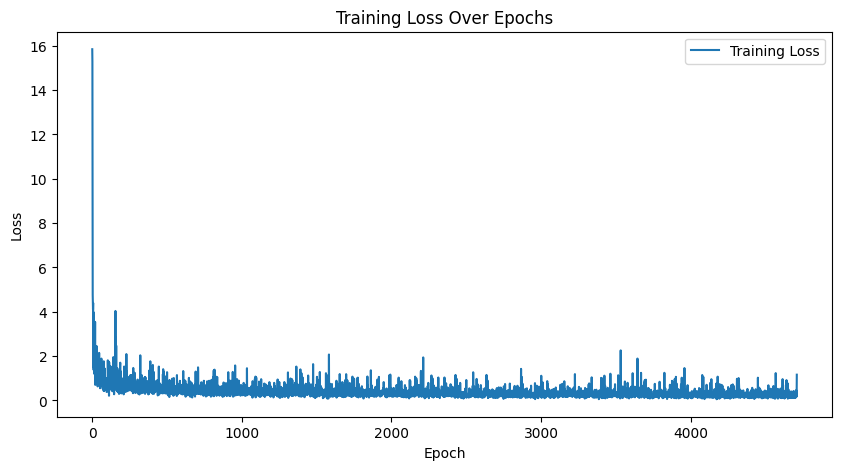

In [25]:
print(train_module.train_losses)
# After training
plt.figure(figsize=(10, 5))
plt.plot(train_module.train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


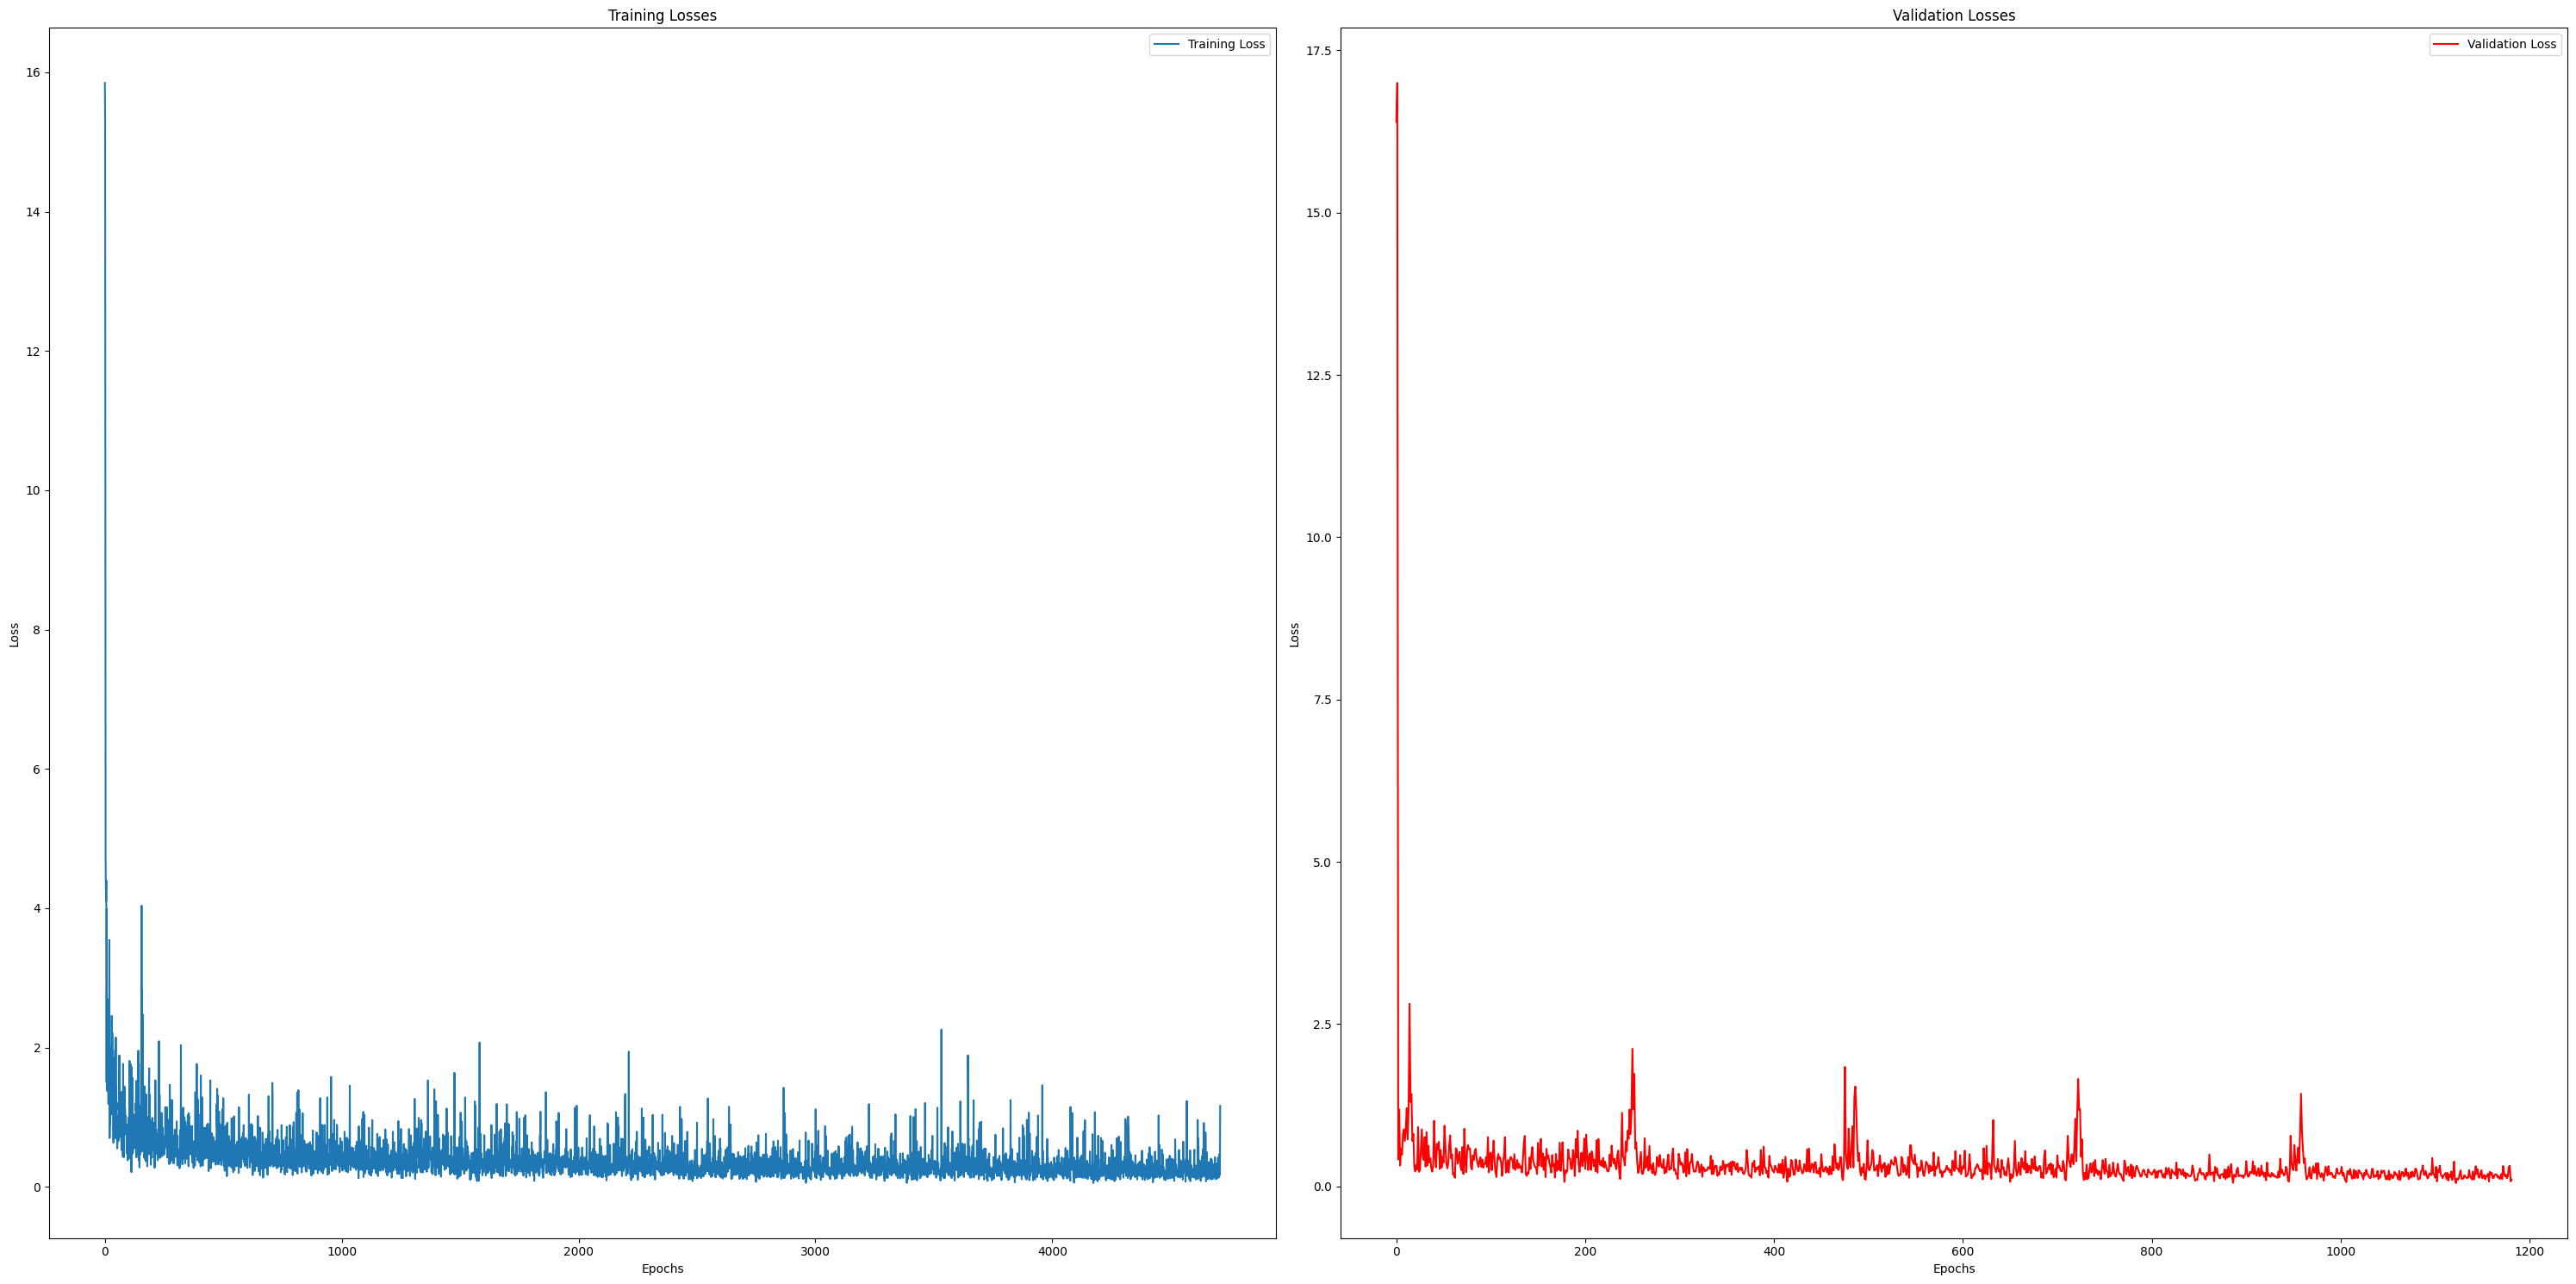

In [26]:
def plot_losses(train_losses, val_losses):
    fig, axs = plt.subplots(1, 2, figsize=(30, 15))

    # Plot all training losses
    axs[0].plot(train_losses, label='Training Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Losses')
    axs[0].legend()

    # Plot all validation losses
    axs[1].plot(val_losses, label='Validation Loss', color='red')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Validation Losses')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

# Plot the extracted losses
plot_losses(train_module.train_losses, train_module.validation_losses)

#### Launch tensorboard for advanced training insights

In [27]:
# #Launch tensorboard for advanced training insights.
# os.system(f"taskkill /pid 19988 /F")

# # Reload the TensorBoard extension to avoid errors about it being already loaded
# %reload_ext tensorboard

# # Start TensorBoard
# %tensorboard --logdir tb_logs/my_model




## Test model

In [28]:
# Assuming you have two dataloaders initialized
dataloaders = [test_synthetic_loader, test_measurement_loader]
trainer.test(train_module, dataloaders=dataloaders)

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Total L1 loss       │   0.025484604761004448    │   0.044321030378341675    │
│      Total auc_ratio      │    0.9958590865135193     │    1.0138676166534424     │
│      Total test_loss      │    0.18331070244312286    │    0.6741655468940735     │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'Total test_loss/dataloader_idx_0': 0.18331070244312286,
  'Total L1 loss/dataloader_idx_0': 0.025484604761004448,
  'Total auc_ratio/dataloader_idx_0': 0.9958590865135193},
 {'Total test_loss/dataloader_idx_1': 0.6741655468940735,
  'Total L1 loss/dataloader_idx_1': 0.044321030378341675,
  'Total auc_ratio/dataloader_idx_1': 1.0138676166534424}]

### Inference with tested model

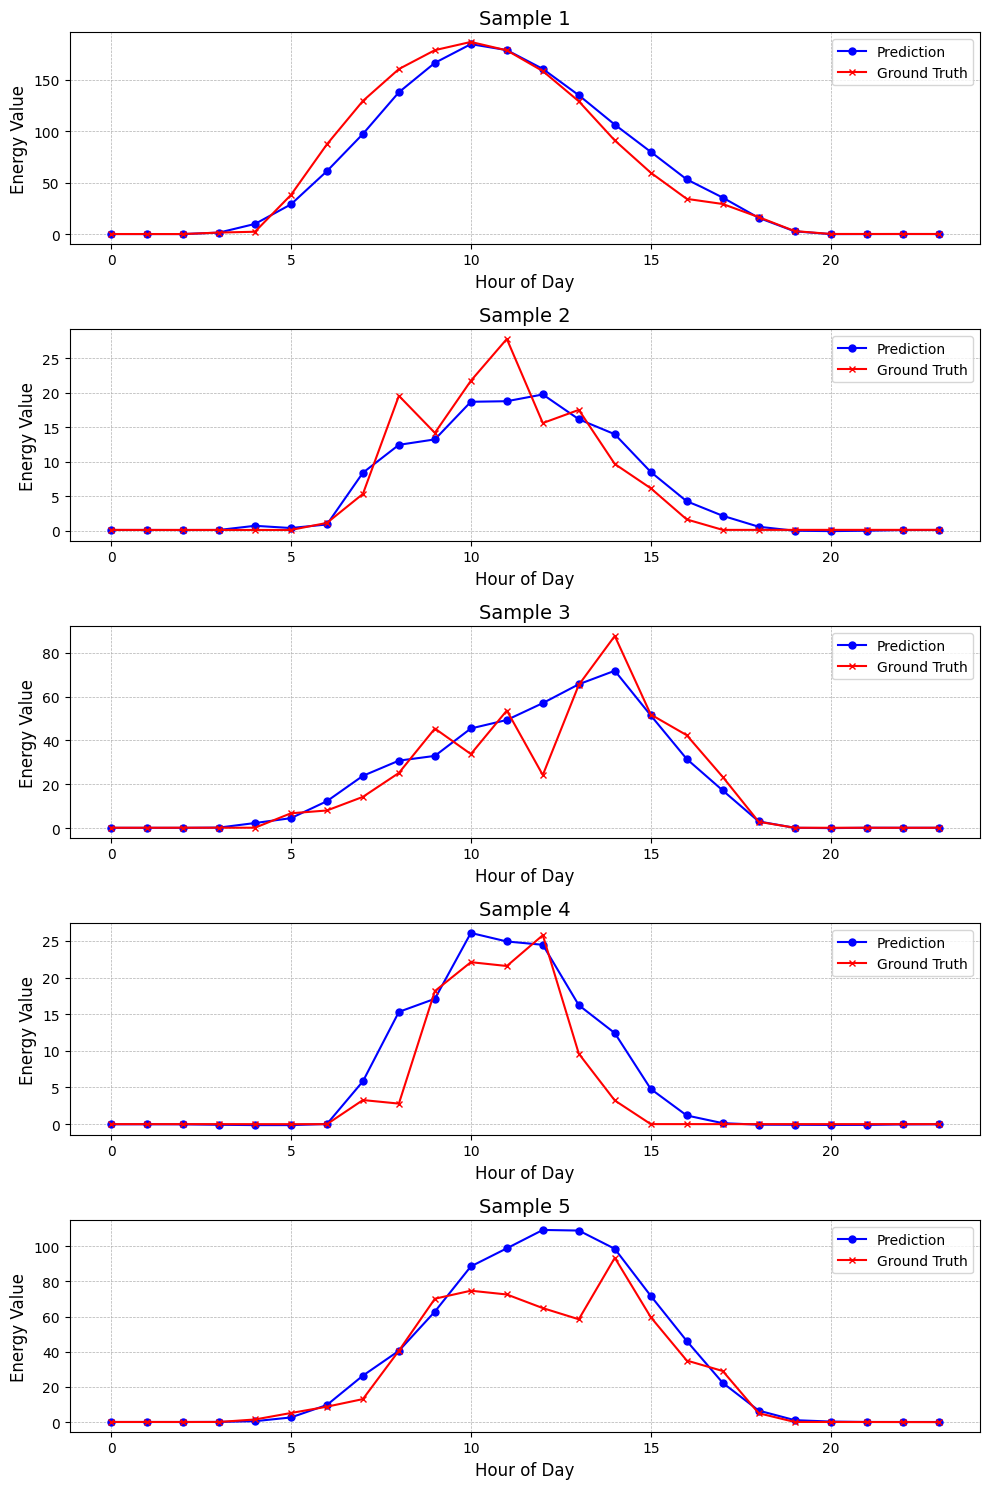

In [29]:
AMOUNT_OF_SAMPLES = 5
# Load the trained model
trained_model = train_module
trained_model.eval()

# Get a batch of samples from the data loader
sample_dynamic, sample_static, ground_truth = next(iter(test_synthetic_loader))
sample_dynamic = sample_dynamic[:AMOUNT_OF_SAMPLES]
sample_static = sample_static[:AMOUNT_OF_SAMPLES]
ground_truth = ground_truth[:AMOUNT_OF_SAMPLES]

# Predict using the batch
with torch.no_grad():
    predictions = trained_model(sample_dynamic, sample_static).numpy()

# Denormalize function using the dataset's method
def denormalize(data, dataset):
    denormalized_data = data * (dataset.output_maxs - dataset.output_mins) + dataset.output_mins
    return denormalized_data

# Denormalize predictions and ground truth
predictions_denorm = denormalize(predictions, dataset)
ground_truth_denorm = denormalize(ground_truth.numpy(), dataset)

# Function to plot energy data
def plot_energy_data(predictions, ground_truth, num_samples=5):
    fig, axes = plt.subplots(AMOUNT_OF_SAMPLES, 1, figsize=(10, num_samples * 3))
    
    if num_samples == 1:
        axes = [axes]
    
    for i in range(num_samples):
        axes[i].plot(predictions[i], label='Prediction', color='blue', linestyle='-', marker='o', markersize=5)
        axes[i].plot(ground_truth[i], label='Ground Truth', color='red', linestyle='-', marker='x', markersize=5)
        axes[i].set_title(f'Sample {i+1}', fontsize=14)
        axes[i].set_xlabel('Hour of Day', fontsize=12)
        axes[i].set_ylabel('Energy Value', fontsize=12)
        axes[i].legend()
        axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the energy data for the specified number of samples
plot_energy_data(predictions_denorm, ground_truth_denorm, num_samples=AMOUNT_OF_SAMPLES)

#### Test on synthetic data

IndexError: index 8 is out of bounds for dimension 0 with size 8

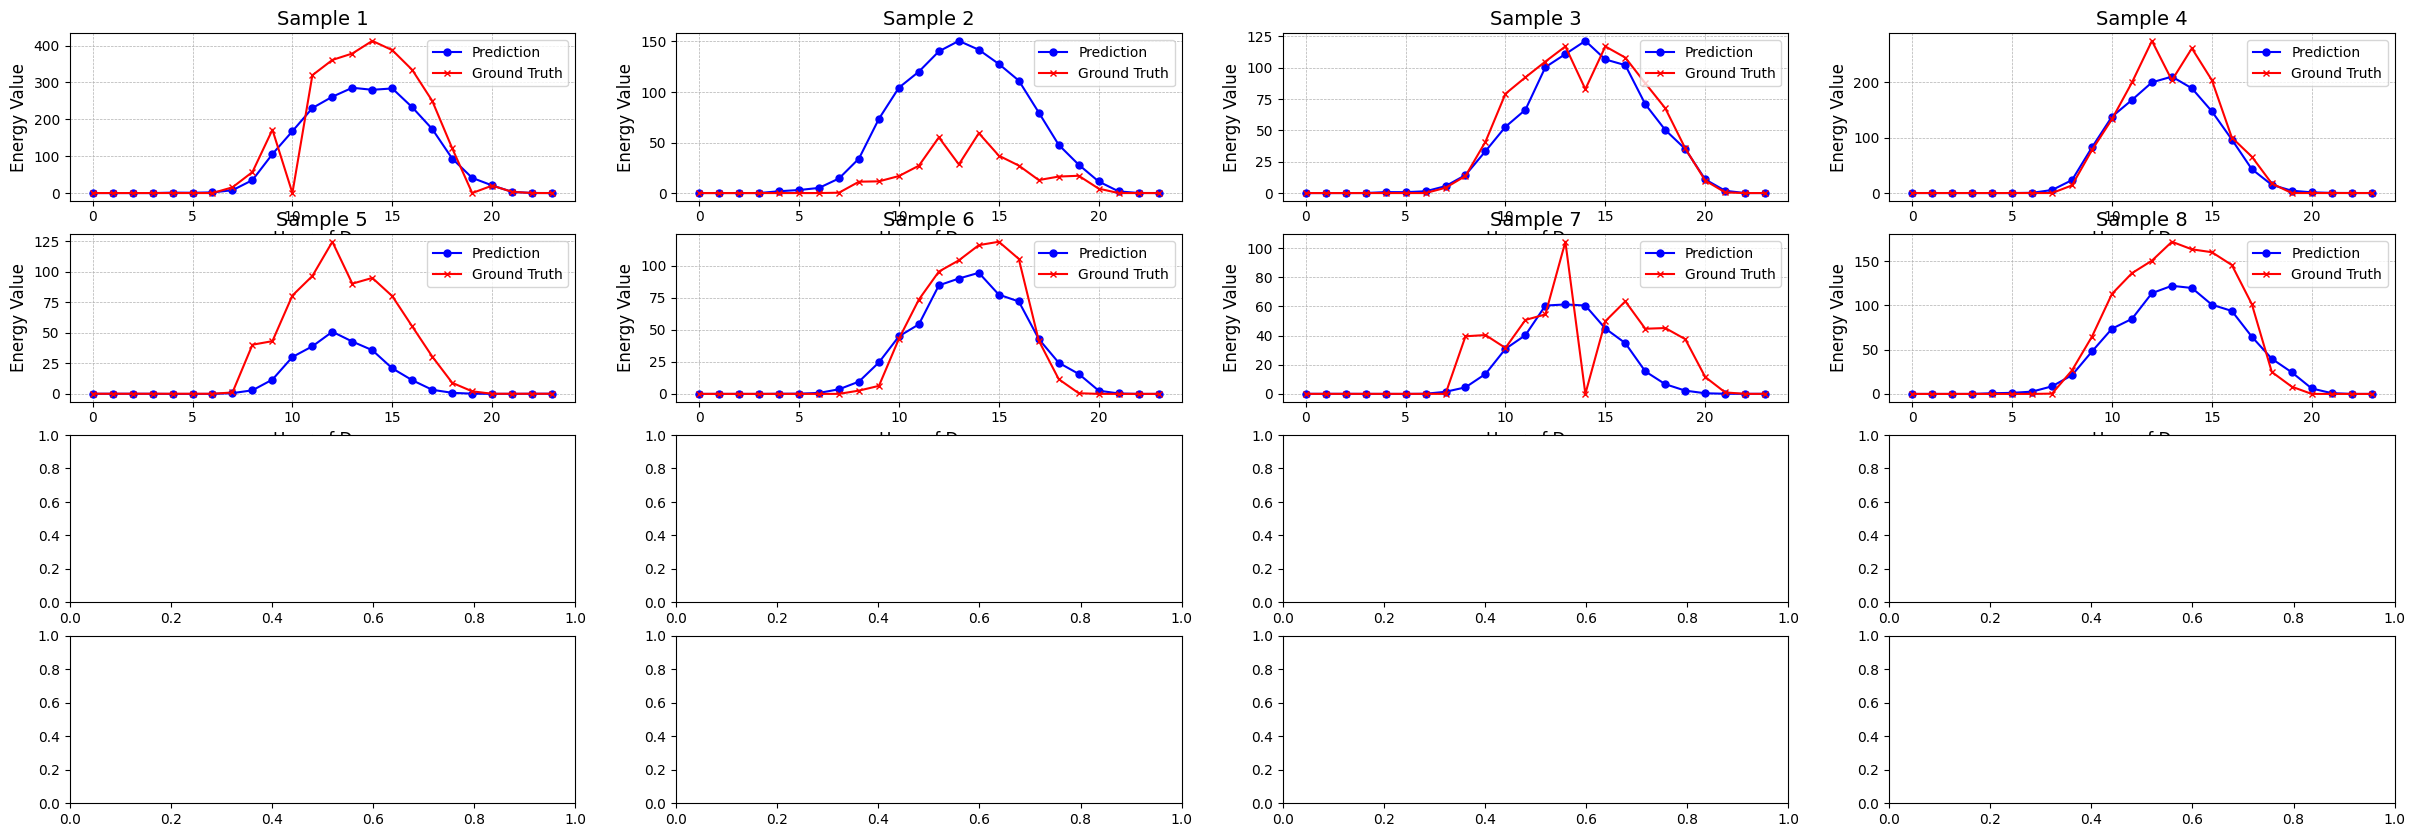

In [30]:
# Load the trained model
trained_model = train_module
trained_model.eval()

# Denormalize function using the dataset's method
def denormalize(data, dataset):
    data = data.numpy()
    denormalized_data = data * (dataset.output_maxs - dataset.output_mins) + dataset.output_mins
    return denormalized_data

# Function to plot 24-hour energy data for multiple samples
def plot_energy_data(samples, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(30, 10))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_y = denormalize(predictions[i], dataset)
        gt_y = denormalize(ground_truth[i], dataset)
        
        # Plot energy data
        ax.plot(pred_y, label='Prediction', color='blue', linestyle='-', marker='o', markersize=5)
        ax.plot(gt_y, label='Ground Truth', color='red', linestyle='-', marker='x', markersize=5)
        ax.set_title(f'Sample {i+1}', fontsize=14)
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Energy Value', fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Number of samples to plot and subplots configuration
num_samples = 16
rows = 4
cols = 4

# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(test_measurement_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = trained_model(samples_dynamic, samples_static)

# Convert predictions and ground truth to numpy if still in tensor form
predictions = predictions
ground_truth = ground_truth

# Plot the 24-hour energy data for the predicted values and ground truth
plot_energy_data(num_samples, predictions, ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)

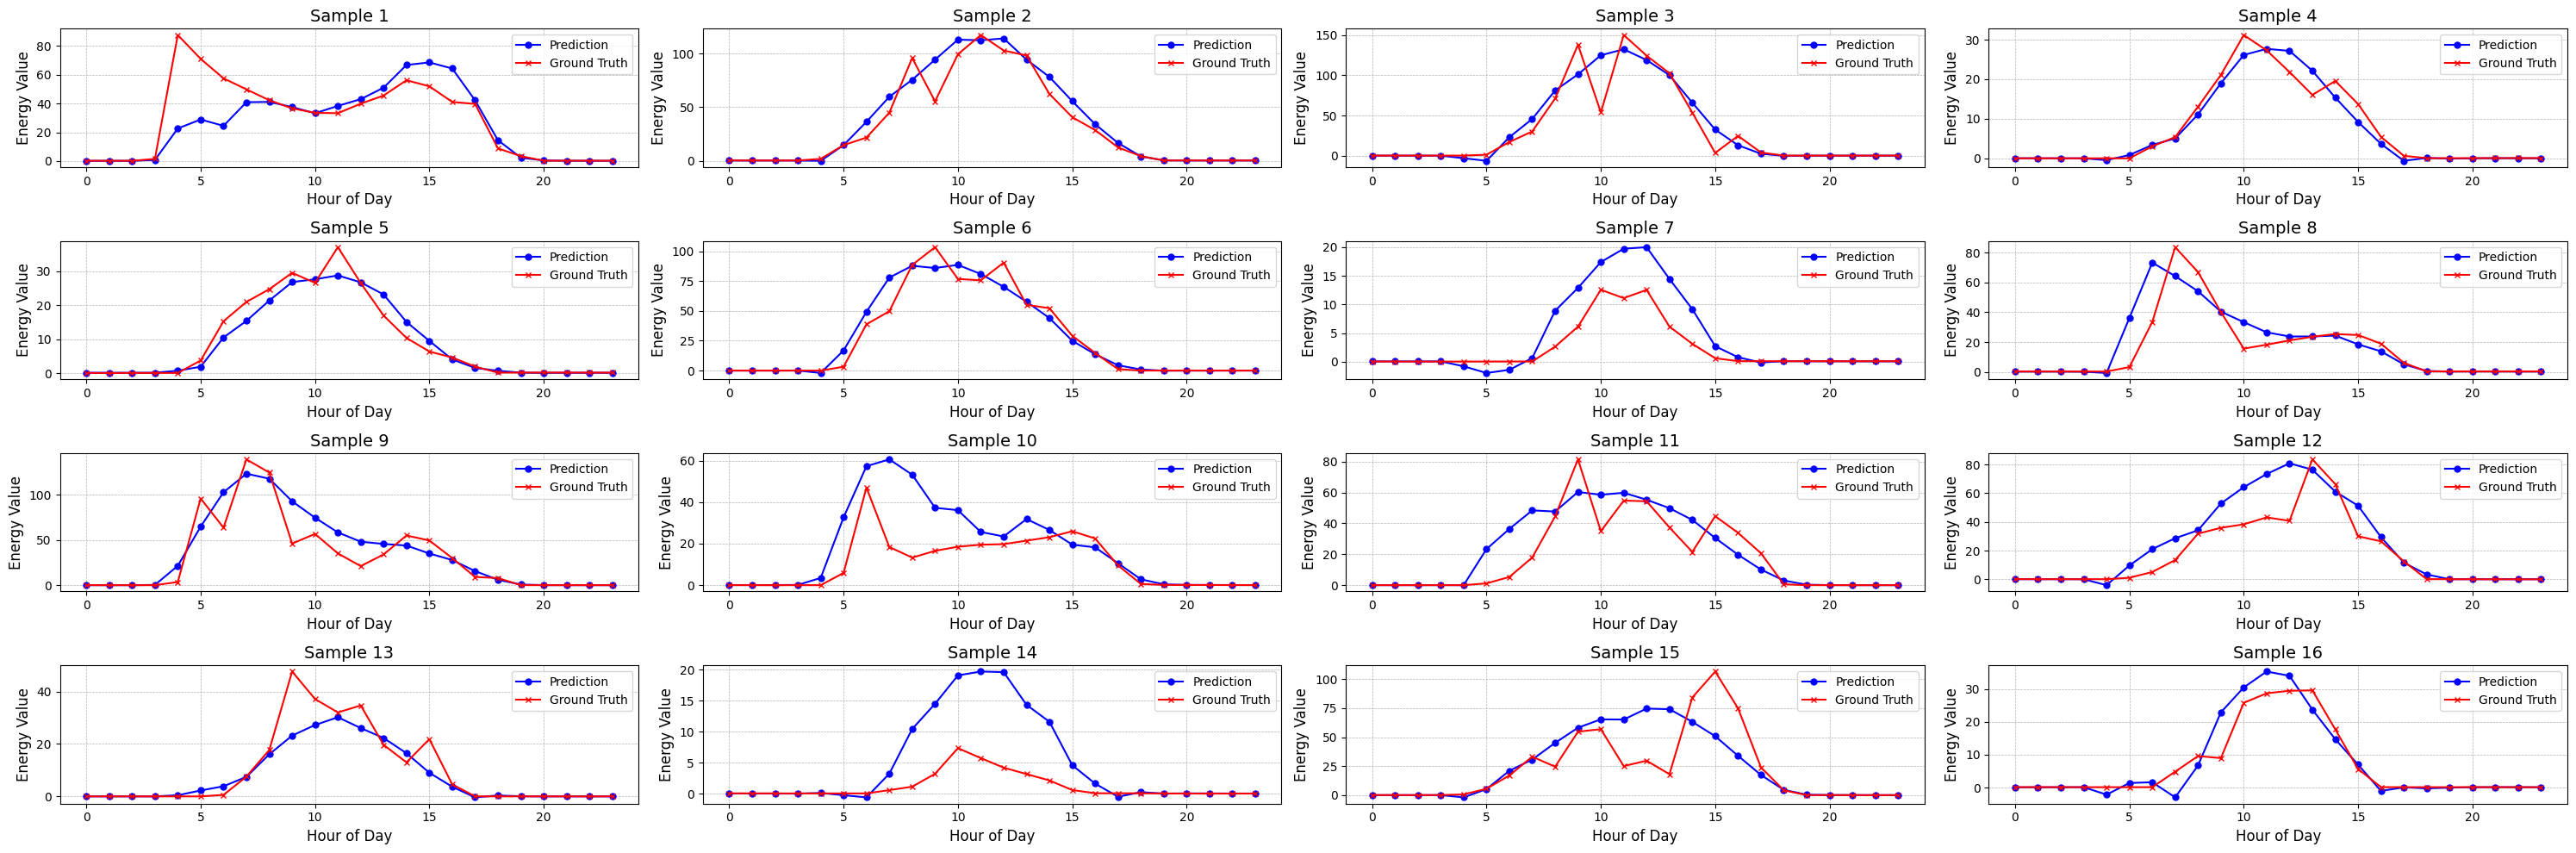

In [ ]:
# Load the trained model
trained_model = train_module
trained_model.eval()

# Denormalize function using the dataset's method
def denormalize(data, dataset):
    data = data.numpy()
    denormalized_data = data * (dataset.output_maxs - dataset.output_mins) + dataset.output_mins
    return denormalized_data

# Function to plot 24-hour energy data for multiple samples
def plot_energy_data(samples, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(30, 10))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_y = denormalize(predictions[i], dataset)
        gt_y = denormalize(ground_truth[i], dataset)
        
        # Plot energy data
        ax.plot(pred_y, label='Prediction', color='blue', linestyle='-', marker='o', markersize=5)
        ax.plot(gt_y, label='Ground Truth', color='red', linestyle='-', marker='x', markersize=5)
        ax.set_title(f'Sample {i+1}', fontsize=14)
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Energy Value', fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Number of samples to plot and subplots configuration
num_samples = 16
rows = 4
cols = 4

# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(test_synthetic_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = trained_model(samples_dynamic, samples_static)

# Convert predictions and ground truth to numpy if still in tensor form
predictions = predictions
ground_truth = ground_truth

# Plot the 24-hour energy data for the predicted values and ground truth
plot_energy_data(num_samples, predictions, ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)

In [ ]:
# import sys 
# sys.exit("Stopping the notebook execution here.")

# Assuming the create_data_loaders function is defined elsewhere
train_loader, val_loader, test_synthetic_loader, test_measurement_loader = create_data_loaders(
    dataset,
    synthetic_sampling_ratio=1,  # 30% of the synthetic dataset
    measured_split_ratio=0.5,    # 50% of the measured dataset for training
    synthetic_split_ratio=0.7,   # 70% of the synthetic dataset for training
    val_ratio=0.2,               # 10% of the training data for validation
    batch_size=64)  # Initial batch size, this will be overwritten by Optuna

def objective(trial, train_loader, val_loader):
    # Define the hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    hidden_size = trial.suggest_categorical("hidden_size",[8,16,32,64,128,256])
    loss_type = trial.suggest_categorical("loss_type", ['mse', 'l1', 'huber'])
    BATCHSIZE = trial.suggest_categorical("batchsize", [8, 16, 32, 64, 128])

    # Update batch size for data loaders
    # train_loader.batch_size = BATCHSIZE
    # val_loader.batch_size = BATCHSIZE

    # Instantiate the model with the suggested hyperparameters
    model = TrainEnergyPrediction(
        dynamic_feature_size=5,  
        static_feature_size=3,  
        hidden_size=hidden_size,
        learning_rate=learning_rate,
        loss_type=loss_type,
    )
    
    logger = CSVLogger("optuna_logs", name="energy_prediction")
    checkpoint_callback = ModelCheckpoint(
        dirpath="models2/",
        filename="best-model-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )
    
    trainer = Trainer(
        logger=logger,
        callbacks=[checkpoint_callback],
        max_epochs=5,
    )
    # Fit the model
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # Use validation loss to determine the best model
    val_loss = trainer.callback_metrics.get("val_loss", float('inf'))

    # Store the best model path in the trial's user attributes
    best_model_path = checkpoint_callback.best_model_path

    if best_model_path:  # Ensure the path is not None or empty
        trial.set_user_attr("best_model_path", best_model_path)
    else:
        raise ValueError("Model checkpoint path is empty!")

    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train_loader, val_loader), n_trials=50, timeout=3600)  # Run for 100 trials or 1 hour

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
print("Best model saved to:", trial.user_attrs.get('best_model_path', 'Not available'))
    
#print("Best model saved to:", trial.user_attrs['best_model_path'])

[I 2024-06-07 13:35:16,037] A new study created in memory with name: no-name-c3b889f5-7d47-40be-adc0-5c0bff89f783
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 9.2 K 
1 | loss_fn | L1Loss                | 0     
--------------------------------------------------
9.2 K     Trainable params
0         Non-trainable params
9.2 K     Total params
0.037     Total estimated model params size (MB)


size of the total dataset: 12750 
size of synthetic data: 12497 = 0.98
size of the measured data: 253 = 0.02

size of the total dataset after subsampling: 12750 
 Size of synthetic data: 12497 = 0.98 
 Size of the measured data: 253 = 0.02 
 ________________________________________________________

Training set size (synthetic): 6998 = 0.56 of synthetic data
Training set size (measured): 101 = 0.40 of measured data 

Validation set size (synthetic): 1749 = 0.14 of synthetic data
Validation set size (measured): 25 = 0.10 of measured data 

Test set size (synthetic): 3750 = 0.30 of synthetic data
Test set size (measured): 127 = 0.50 of measured data 



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 372.17477 (best 372.17477), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=372.17.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 148.56384 (best 148.56384), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=148.56.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 122.20980 (best 122.20980), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=122.21.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 112.67927 (best 112.67927), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=112.68.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 106.13869 (best 106.13869), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=106.14.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:36:08,724] Trial 0 finished with value: 106.13868713378906 and parameters: {'learning_rate': 0.00028499897083199055, 'hidden_size': 32, 'loss_type': 'l1', 'batchsize': 32}. Best is trial 0 with value: 106.13868713378906.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type             

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 8.94673 (best 8.94673), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=8.95.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 7.59849 (best 7.59849), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=7.60.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:37:01,729] Trial 1 finished with value: 7.895296096801758 and parameters: {'learning_rate': 0.09420227038278134, 'hidden_size': 8, 'loss_type': 'huber', 'batchsize': 128}. Best is trial 1 with value: 7.895296096801758.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 9.2 K 
1 | loss_fn | L1Loss                | 0     
--------------------------------------------------
9.2 K   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 503.87354 (best 503.87354), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=503.87.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 497.54468 (best 497.54468), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=497.54.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 490.84323 (best 490.84323), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=490.84.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 483.62845 (best 483.62845), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=483.63.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 475.73730 (best 475.73730), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=475.74.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:37:54,571] Trial 2 finished with value: 475.7373046875 and parameters: {'learning_rate': 1.7306757158551182e-05, 'hidden_size': 32, 'loss_type': 'l1', 'batchsize': 32}. Best is trial 1 with value: 7.895296096801758.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 123.98804 (best 123.98804), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=123.99.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 97.03680 (best 97.03680), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=97.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 96.60791 (best 96.60791), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=96.61.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 92.85078 (best 92.85078), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=92.85.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 87.69166 (best 87.69166), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=87.69.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:38:44,255] Trial 3 finished with value: 87.69165802001953 and parameters: {'learning_rate': 0.05006283843127145, 'hidden_size': 8, 'loss_type': 'l1', 'batchsize': 64}. Best is trial 1 with value: 7.895296096801758.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Pa

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 95.99272 (best 95.99272), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=95.99.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 89.97754 (best 89.97754), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=89.98.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 81.34846 (best 81.34846), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=81.35.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 68.11781 (best 68.11781), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=68.12.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 48.48573 (best 48.48573), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=48.49.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:39:37,391] Trial 4 finished with value: 48.48572540283203 and parameters: {'learning_rate': 1.4007550507439762e-05, 'hidden_size': 128, 'loss_type': 'huber', 'batchsize': 16}. Best is trial 1 with value: 7.895296096801758.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type              

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 8.01870 (best 8.01870), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=8.02.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 6.08019 (best 6.08019), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=6.08.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 5.74757 (best 5.74757), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=5.75.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 5.50027 (best 5.50027), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=5.50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 5.40211 (best 5.40211), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=5.40.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:40:25,473] Trial 5 finished with value: 5.402111530303955 and parameters: {'learning_rate': 0.01206173150448807, 'hidden_size': 8, 'loss_type': 'huber', 'batchsize': 8}. Best is trial 5 with value: 5.402111530303955.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 104.72945 (best 104.72945), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=104.73.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 104.12928 (best 104.12928), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=104.13.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 103.54410 (best 103.54410), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=103.54.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 102.96582 (best 102.96582), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=102.97.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 102.38758 (best 102.38758), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=102.39.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:41:14,531] Trial 6 finished with value: 102.38758087158203 and parameters: {'learning_rate': 1.729628893921291e-05, 'hidden_size': 8, 'loss_type': 'huber', 'batchsize': 32}. Best is trial 5 with value: 5.402111530303955.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type             

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 203.97728 (best 203.97728), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=203.98.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 201.70276 (best 201.70276), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=201.70.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 199.37868 (best 199.37868), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=199.38.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 196.96095 (best 196.96095), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=196.96.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 194.38264 (best 194.38264), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=194.38.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:42:01,270] Trial 7 finished with value: 194.3826446533203 and parameters: {'learning_rate': 2.9077831535395238e-05, 'hidden_size': 8, 'loss_type': 'mse', 'batchsize': 16}. Best is trial 5 with value: 5.402111530303955.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type               

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 79.98860 (best 79.98860), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=79.99.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 31.98434 (best 31.98434), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=31.98.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 19.77480 (best 19.77480), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=19.77.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 16.00079 (best 16.00079), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=16.00.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 14.21652 (best 14.21652), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=14.22.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:42:57,216] Trial 8 finished with value: 14.216519355773926 and parameters: {'learning_rate': 2.406519781081988e-05, 'hidden_size': 256, 'loss_type': 'huber', 'batchsize': 16}. Best is trial 5 with value: 5.402111530303955.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type              

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 183.80403 (best 183.80403), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=183.80.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 136.21968 (best 136.21968), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=136.22.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 61.24165 (best 61.24165), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=61.24.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 41.54080 (best 41.54080), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=41.54.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 34.01648 (best 34.01648), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=34.02.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:43:47,669] Trial 9 finished with value: 34.016483306884766 and parameters: {'learning_rate': 3.494999075370895e-05, 'hidden_size': 128, 'loss_type': 'mse', 'batchsize': 8}. Best is trial 5 with value: 5.402111530303955.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 7.23759 (best 7.23759), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=7.24.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 5.15089 (best 5.15089), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=5.15.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.41800 (best 4.41800), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.42.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 3.91521 (best 3.91521), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=3.92.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 3.56877 (best 3.56877), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=3.57.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:44:37,346] Trial 10 finished with value: 3.5687663555145264 and parameters: {'learning_rate': 0.006397238070565401, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 8}. Best is trial 10 with value: 3.5687663555145264.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 7.00174 (best 7.00174), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=7.00.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 5.18920 (best 5.18920), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=5.19.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.71380 (best 4.71380), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.71.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 4.20967 (best 4.20967), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=4.21.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 3.73986 (best 3.73986), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=3.74.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:45:51,461] Trial 11 finished with value: 3.739863872528076 and parameters: {'learning_rate': 0.007126747509003695, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 8}. Best is trial 10 with value: 3.5687663555145264.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 7.29654 (best 7.29654), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=7.30.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 5.12755 (best 5.12755), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=5.13.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.77040 (best 4.77040), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.77.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 4.41806 (best 4.41806), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=4.42.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 3.82137 (best 3.82137), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=3.82.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:46:45,135] Trial 12 finished with value: 3.8213748931884766 and parameters: {'learning_rate': 0.0032985702237470034, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 8}. Best is trial 10 with value: 3.5687663555145264.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 10.10590 (best 10.10590), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=10.11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 6.35291 (best 6.35291), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=6.35.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 5.29876 (best 5.29876), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=5.30.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 4.71030 (best 4.71030), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=4.71.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 4.11478 (best 4.11478), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=4.11.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:47:39,554] Trial 13 finished with value: 4.114780426025391 and parameters: {'learning_rate': 0.0011982704905881137, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 8}. Best is trial 10 with value: 3.5687663555145264.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 6.39745 (best 6.39745), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=6.40.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 4.87278 (best 4.87278), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=4.87.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.19267 (best 4.19267), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.19.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 3.89956 (best 3.89956), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=3.90.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 3.50661 (best 3.50661), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=3.51.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:48:32,172] Trial 14 finished with value: 3.5066118240356445 and parameters: {'learning_rate': 0.009559437193903978, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 8}. Best is trial 14 with value: 3.5066118240356445.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 14.66968 (best 14.66968), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=14.67.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 13.37932 (best 13.37932), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=13.38.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 11.15420 (best 11.15420), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=11.15.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 10.53281 (best 10.53281), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=10.53.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 9.28583 (best 9.28583), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=9.29.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:49:22,289] Trial 15 finished with value: 9.285833358764648 and parameters: {'learning_rate': 0.021694111350627102, 'hidden_size': 16, 'loss_type': 'mse', 'batchsize': 128}. Best is trial 14 with value: 3.5066118240356445.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 18.56495 (best 18.56495), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=18.56.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 11.98236 (best 11.98236), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=11.98.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 10.30173 (best 10.30173), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=10.30.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 8.88168 (best 8.88168), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=8.88.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 7.64167 (best 7.64167), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=7.64.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:50:15,051] Trial 16 finished with value: 7.641666412353516 and parameters: {'learning_rate': 0.00028659405026881183, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 64}. Best is trial 14 with value: 3.5066118240356445.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type               

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 8.54732 (best 8.54732), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=8.55.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 5.41769 (best 5.41769), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=5.42.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.47988 (best 4.47988), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.48.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 3.99083 (best 3.99083), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=3.99.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 3.62924 (best 3.62924), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=3.63.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:51:05,508] Trial 17 finished with value: 3.629241704940796 and parameters: {'learning_rate': 0.002705607871457961, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 8}. Best is trial 14 with value: 3.5066118240356445.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 101.90870 (best 101.90870), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=101.91.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 77.14622 (best 77.14622), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=77.15.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 70.34231 (best 70.34231), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=70.34.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 66.44233 (best 66.44233), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=66.44.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 61.04693 (best 61.04693), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=61.05.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:52:07,021] Trial 18 finished with value: 61.04692840576172 and parameters: {'learning_rate': 0.00044786127237746355, 'hidden_size': 256, 'loss_type': 'l1', 'batchsize': 8}. Best is trial 14 with value: 3.5066118240356445.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type               

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 13.19496 (best 13.19496), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=13.19.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 10.86563 (best 10.86563), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=10.87.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 10.63689 (best 10.63689), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=10.64.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 8.89390 (best 8.89390), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=8.89.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 8.43625 (best 8.43625), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=8.44.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:52:57,931] Trial 19 finished with value: 8.436254501342773 and parameters: {'learning_rate': 0.02283509726764422, 'hidden_size': 16, 'loss_type': 'mse', 'batchsize': 8}. Best is trial 14 with value: 3.5066118240356445.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | P

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 7.30282 (best 7.30282), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=7.30.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 5.12112 (best 5.12112), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=5.12.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.35431 (best 4.35431), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.35.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 3.67681 (best 3.67681), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=3.68.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 3.60150 (best 3.60150), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=3.60.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:53:49,743] Trial 20 finished with value: 3.601504325866699 and parameters: {'learning_rate': 0.0034451796964080363, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 128}. Best is trial 14 with value: 3.5066118240356445.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type               

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 7.16139 (best 7.16139), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=7.16.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 5.47302 (best 5.47302), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=5.47.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.58259 (best 4.58259), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.58.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 3.93790 (best 3.93790), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=3.94.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 3.71049 (best 3.71049), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=3.71-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:54:41,977] Trial 21 finished with value: 3.710488796234131 and parameters: {'learning_rate': 0.005420242997080894, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 128}. Best is trial 14 with value: 3.5066118240356445.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type             

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 9.90485 (best 9.90485), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=9.90.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 6.74344 (best 6.74344), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=6.74.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 5.43571 (best 5.43571), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=5.44.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 4.93084 (best 4.93084), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=4.93.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 4.41579 (best 4.41579), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=4.42.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:55:34,430] Trial 22 finished with value: 4.415789604187012 and parameters: {'learning_rate': 0.0013100017232295926, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 128}. Best is trial 14 with value: 3.5066118240356445.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type               

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 7.08621 (best 7.08621), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=7.09.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 5.22258 (best 5.22258), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=5.22.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.78362 (best 4.78362), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.78.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 3.99547 (best 3.99547), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=4.00.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:56:25,670] Trial 23 finished with value: 4.109614372253418 and parameters: {'learning_rate': 0.012559499817495217, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 128}. Best is trial 14 with value: 3.5066118240356445.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 30.6 K
1 | loss_fn | HuberLoss             | 0     
--------------------------------------------------
30.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 7.17481 (best 7.17481), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=7.17.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 5.22613 (best 5.22613), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=5.23.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.56071 (best 4.56071), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.56.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 4.23299 (best 4.23299), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=4.23.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 3.80889 (best 3.80889), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=3.81.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:57:18,679] Trial 24 finished with value: 3.808891773223877 and parameters: {'learning_rate': 0.002479277384115657, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 64}. Best is trial 14 with value: 3.5066118240356445.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 12.48871 (best 12.48871), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=12.49.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 8.67978 (best 8.67978), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=8.68.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 6.65178 (best 6.65178), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=6.65.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 5.76197 (best 5.76197), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=5.76.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 5.18363 (best 5.18363), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=5.18.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:58:09,984] Trial 25 finished with value: 5.1836323738098145 and parameters: {'learning_rate': 0.0006264597597718713, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 128}. Best is trial 14 with value: 3.5066118240356445.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type              

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 73.68159 (best 73.68159), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=73.68.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 20.88171 (best 20.88171), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=20.88.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 14.40115 (best 14.40115), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=14.40.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 12.46363 (best 12.46363), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=12.46.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 11.46459 (best 11.46459), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=11.46.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:59:03,907] Trial 26 finished with value: 11.464592933654785 and parameters: {'learning_rate': 0.0001308776731779959, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 8}. Best is trial 14 with value: 3.5066118240356445.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type             

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 7.09506 (best 7.09506), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=7.10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 5.37979 (best 5.37979), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=5.38.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.97245 (best 4.97245), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.97.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 4.33851 (best 4.33851), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=4.34.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 3.98321 (best 3.98321), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=3.98.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 13:59:53,684] Trial 27 finished with value: 3.9832117557525635 and parameters: {'learning_rate': 0.027455964749265864, 'hidden_size': 32, 'loss_type': 'huber', 'batchsize': 8}. Best is trial 14 with value: 3.5066118240356445.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 144.09822 (best 144.09822), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=144.10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 125.08485 (best 125.08485), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=125.08.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 88.55351 (best 88.55351), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=88.55.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 74.95385 (best 74.95385), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=74.95.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:00:46,618] Trial 28 finished with value: 74.95384979248047 and parameters: {'learning_rate': 0.006230921161628023, 'hidden_size': 128, 'loss_type': 'l1', 'batchsize': 128}. Best is trial 14 with value: 3.5066118240356445.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type               

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 28.84953 (best 28.84953), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=28.85.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 22.03245 (best 22.03245), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=22.03.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 18.52374 (best 18.52374), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=18.52.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 14.64497 (best 14.64497), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=14.64.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 12.71478 (best 12.71478), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=12.71.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:01:35,370] Trial 29 finished with value: 12.714784622192383 and parameters: {'learning_rate': 0.0019011153541982327, 'hidden_size': 16, 'loss_type': 'mse', 'batchsize': 32}. Best is trial 14 with value: 3.5066118240356445.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type              

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 103.16879 (best 103.16879), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=103.17.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 82.09225 (best 82.09225), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=82.09.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 78.35368 (best 78.35368), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=78.35.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 76.76192 (best 76.76192), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=76.76.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 71.53467 (best 71.53467), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=71.53.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:02:35,619] Trial 30 finished with value: 71.53466796875 and parameters: {'learning_rate': 0.012638788884841656, 'hidden_size': 256, 'loss_type': 'l1', 'batchsize': 64}. Best is trial 14 with value: 3.5066118240356445.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 6.22883 (best 6.22883), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=6.23.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 4.98871 (best 4.98871), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=4.99.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.25658 (best 4.25658), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.26.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 3.75456 (best 3.75456), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=3.75.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 3.35725 (best 3.35725), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=3.36.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:03:26,332] Trial 31 finished with value: 3.3572492599487305 and parameters: {'learning_rate': 0.004172022493806839, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 8}. Best is trial 31 with value: 3.3572492599487305.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 6.22151 (best 6.22151), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=6.22.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 4.86881 (best 4.86881), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=4.87.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.20371 (best 4.20371), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.20.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 3.66764 (best 3.66764), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=3.67.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 3.47093 (best 3.47093), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=3.47.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:04:16,676] Trial 32 finished with value: 3.470931053161621 and parameters: {'learning_rate': 0.004716085641027154, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 8}. Best is trial 31 with value: 3.3572492599487305.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 6.61171 (best 6.61171), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=6.61.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 5.24896 (best 5.24896), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=5.25.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.37673 (best 4.37673), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.38.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 4.31325 (best 4.31325), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=4.31.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 3.94499 (best 3.94499), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=3.94.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:05:05,775] Trial 33 finished with value: 3.944988250732422 and parameters: {'learning_rate': 0.008431437297175914, 'hidden_size': 32, 'loss_type': 'huber', 'batchsize': 8}. Best is trial 31 with value: 3.3572492599487305.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 9.08614 (best 9.08614), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=9.09.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 8.90456 (best 8.90456), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=8.90.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 8.19247 (best 8.19247), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=8.19.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 7.50674 (best 7.50674), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=7.51.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:06:01,350] Trial 34 finished with value: 7.506738185882568 and parameters: {'learning_rate': 0.08331017889006474, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 8}. Best is trial 31 with value: 3.3572492599487305.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 7.69089 (best 7.69089), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=7.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 5.73278 (best 5.73278), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=5.73.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.68331 (best 4.68331), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.68.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 3.91495 (best 3.91495), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=3.91.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 3.50339 (best 3.50339), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=3.50.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:06:56,764] Trial 35 finished with value: 3.5033884048461914 and parameters: {'learning_rate': 0.004792218449492476, 'hidden_size': 64, 'loss_type': 'huber', 'batchsize': 8}. Best is trial 31 with value: 3.3572492599487305.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 84.15553 (best 84.15553), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=84.16.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 74.03222 (best 74.03222), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=74.03.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 71.97401 (best 71.97401), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=71.97.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 67.60460 (best 67.60460), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=67.60.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:07:51,677] Trial 36 finished with value: 69.5306625366211 and parameters: {'learning_rate': 0.04495968943547945, 'hidden_size': 64, 'loss_type': 'l1', 'batchsize': 8}. Best is trial 31 with value: 3.3572492599487305.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 9.2 K 
1 | loss_fn | HuberLoss             | 0     
--------------------------------------------------
9.2 K     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 14.59866 (best 14.59866), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=14.60.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 10.60811 (best 10.60811), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=10.61.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 8.45448 (best 8.45448), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=8.45.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 7.29300 (best 7.29300), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=7.29.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 6.52628 (best 6.52628), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=6.53.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:08:43,717] Trial 37 finished with value: 6.526280879974365 and parameters: {'learning_rate': 0.0008493703115479935, 'hidden_size': 32, 'loss_type': 'huber', 'batchsize': 32}. Best is trial 31 with value: 3.3572492599487305.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 8.19513 (best 8.19513), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=8.20.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 4.95908 (best 4.95908), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=4.96.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 3.88664 (best 3.88664), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=3.89.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 3.28619 (best 3.28619), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=3.29.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 2.81168 (best 2.81168), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=2.81.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:09:39,334] Trial 38 finished with value: 2.8116824626922607 and parameters: {'learning_rate': 0.004190671152422767, 'hidden_size': 128, 'loss_type': 'huber', 'batchsize': 8}. Best is trial 38 with value: 2.8116824626922607.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 6.64976 (best 6.64976), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=6.65.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 4.85571 (best 4.85571), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=4.86.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 3.70775 (best 3.70775), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=3.71.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 3.33139 (best 3.33139), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=3.33.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 2.97048 (best 2.97048), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=2.97.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:10:34,498] Trial 39 finished with value: 2.9704785346984863 and parameters: {'learning_rate': 0.004172224655157406, 'hidden_size': 128, 'loss_type': 'huber', 'batchsize': 16}. Best is trial 38 with value: 2.8116824626922607.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type               

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 7.27156 (best 7.27156), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=7.27.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 5.08554 (best 5.08554), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=5.09.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.16686 (best 4.16686), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.17.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 3.73607 (best 3.73607), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=3.74.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 3.32792 (best 3.32792), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=3.33.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:11:31,492] Trial 40 finished with value: 3.3279178142547607 and parameters: {'learning_rate': 0.001442703377232021, 'hidden_size': 128, 'loss_type': 'huber', 'batchsize': 16}. Best is trial 38 with value: 2.8116824626922607.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type               

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 6.66467 (best 6.66467), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=6.66.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 5.13614 (best 5.13614), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=5.14.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.24024 (best 4.24024), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.24.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 3.91299 (best 3.91299), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=3.91.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 3.17079 (best 3.17079), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=3.17.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:12:27,997] Trial 41 finished with value: 3.170790910720825 and parameters: {'learning_rate': 0.00176566218415224, 'hidden_size': 128, 'loss_type': 'huber', 'batchsize': 16}. Best is trial 38 with value: 2.8116824626922607.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 6.95502 (best 6.95502), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=6.96.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 5.18440 (best 5.18440), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=5.18.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.44959 (best 4.44959), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.45.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 4.01726 (best 4.01726), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=4.02.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 3.53375 (best 3.53375), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=3.53.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:13:24,222] Trial 42 finished with value: 3.5337512493133545 and parameters: {'learning_rate': 0.0016732987596525452, 'hidden_size': 128, 'loss_type': 'huber', 'batchsize': 16}. Best is trial 38 with value: 2.8116824626922607.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type              

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 9.09218 (best 9.09218), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=9.09.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 6.05458 (best 6.05458), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=6.05.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 5.03370 (best 5.03370), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=5.03.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 4.52724 (best 4.52724), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=4.53.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 4.17776 (best 4.17776), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=4.18.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:14:19,310] Trial 43 finished with value: 4.177760601043701 and parameters: {'learning_rate': 0.0008965255341055046, 'hidden_size': 128, 'loss_type': 'huber', 'batchsize': 16}. Best is trial 38 with value: 2.8116824626922607.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type               

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 7.00231 (best 7.00231), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=7.00.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 5.10098 (best 5.10098), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=5.10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.23530 (best 4.23530), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.24.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 3.72816 (best 3.72816), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=3.73.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 2.94206 (best 2.94206), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=2.94.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:15:16,411] Trial 44 finished with value: 2.9420597553253174 and parameters: {'learning_rate': 0.0018953383953669064, 'hidden_size': 128, 'loss_type': 'huber', 'batchsize': 16}. Best is trial 38 with value: 2.8116824626922607.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type              

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 10.85036 (best 10.85036), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=10.85.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 7.49554 (best 7.49554), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=7.50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 5.86634 (best 5.86634), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=5.87.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 5.05356 (best 5.05356), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=5.05.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 4.57094 (best 4.57094), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=4.57.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:16:13,681] Trial 45 finished with value: 4.570944309234619 and parameters: {'learning_rate': 0.00046868553832728205, 'hidden_size': 128, 'loss_type': 'huber', 'batchsize': 16}. Best is trial 38 with value: 2.8116824626922607.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type              

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 14.21601 (best 14.21601), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=14.22.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 9.91948 (best 9.91948), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=9.92.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 8.71598 (best 8.71598), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=8.72.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 8.05915 (best 8.05915), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=8.06.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 7.06717 (best 7.06717), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=7.07.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:17:13,764] Trial 46 finished with value: 7.067171096801758 and parameters: {'learning_rate': 0.0018002633164525138, 'hidden_size': 128, 'loss_type': 'mse', 'batchsize': 16}. Best is trial 38 with value: 2.8116824626922607.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 35.74273 (best 35.74273), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=35.74.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 14.24155 (best 14.24155), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=14.24.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 12.04714 (best 12.04714), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=12.05.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 10.97952 (best 10.97952), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=10.98.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 10.19685 (best 10.19685), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=10.20.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:18:10,906] Trial 47 finished with value: 10.196845054626465 and parameters: {'learning_rate': 0.00010069333051729404, 'hidden_size': 128, 'loss_type': 'huber', 'batchsize': 16}. Best is trial 38 with value: 2.8116824626922607.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type          

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 83.42580 (best 83.42580), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=83.43.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 70.41495 (best 70.41495), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=70.41.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 63.84894 (best 63.84894), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=63.85.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 58.45912 (best 58.45912), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=58.46.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 56.33210 (best 56.33210), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=56.33.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:19:08,310] Trial 48 finished with value: 56.33209991455078 and parameters: {'learning_rate': 0.0023221825801758053, 'hidden_size': 128, 'loss_type': 'l1', 'batchsize': 16}. Best is trial 38 with value: 2.8116824626922607.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type               

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 111: 'val_loss' reached 7.52210 (best 7.52210), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_loss=7.52.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 222: 'val_loss' reached 5.55516 (best 5.55516), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_loss=5.56.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 333: 'val_loss' reached 4.74392 (best 4.74392), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_loss=4.74.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 444: 'val_loss' reached 3.97792 (best 3.97792), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_loss=3.98.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 555: 'val_loss' reached 3.47189 (best 3.47189), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=3.47-v1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-07 14:20:05,334] Trial 49 finished with value: 3.471886157989502 and parameters: {'learning_rate': 0.001186652309986811, 'hidden_size': 128, 'loss_type': 'huber', 'batchsize': 16}. Best is trial 38 with value: 2.8116824626922607.


Best trial:
  Value:  2.8116824626922607
  Params: 
    learning_rate: 0.004190671152422767
    hidden_size: 128
    loss_type: huber
    batchsize: 8
Best model saved to: C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2\best-model-epoch=04-val_loss=2.81.ckpt


In [ ]:
def save_hyperparameters(trial, filename="hyperparameters.txt"):
    with open(filename, "w") as f:
        for key, value in trial.params.items():
            f.write(f"{key}: {value}\n")

def load_model(checkpoint_path, trial):
    # Extract hyperparameters from the trial
    learning_rate = trial.params['learning_rate']
    hidden_size = trial.params['hidden_size']
    loss_type = trial.params['loss_type']
    

    # Instantiate the model with the trial's hyperparameters
    model = TrainEnergyPrediction(
        dynamic_feature_size=5,  
        static_feature_size=3,  
        hidden_size=hidden_size,
        learning_rate=learning_rate,
        loss_type=loss_type,
    )
    
    # Load the model's weights from the checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

def evaluate_model(model, test_loader):
    trainer = Trainer(logger=False)
    results = trainer.test(model, dataloaders=test_loader)
    return results

# Retrieve the best trial
best_trial = study.best_trial
print(best_trial)

# Print all user attributes to debug
print("User attributes of the best trial:", best_trial.user_attrs)

# Check if 'best_model_path' is present
if 'best_model_path' in best_trial.user_attrs:
    checkpoint_path = best_trial.user_attrs['best_model_path']

    # Load the best model
    model = load_model(checkpoint_path, best_trial)
    torch.save(model.state_dict(), f"{checkpoint_path}.pth")
    save_hyperparameters(trial, filename=f"{checkpoint_path}_hyperparams.txt")

    print(f"Evaluating best model from trial {best_trial.number}")

    # Evaluate on both synthetic and measurement test loaders
    model_results = evaluate_model(model, [test_synthetic_loader,test_measurement_loader])
    print("Results for the best model:")
    print("Synthetic Test Set:", model_results)
    
else:
    print("Best model path not found in the best trial's user attributes.")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


FrozenTrial(number=38, state=1, values=[2.8116824626922607], datetime_start=datetime.datetime(2024, 6, 7, 14, 8, 43, 718479), datetime_complete=datetime.datetime(2024, 6, 7, 14, 9, 39, 333974), params={'learning_rate': 0.004190671152422767, 'hidden_size': 128, 'loss_type': 'huber', 'batchsize': 8}, user_attrs={'best_model_path': 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_loss=2.81.ckpt'}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'hidden_size': CategoricalDistribution(choices=(8, 16, 32, 64, 128, 256)), 'loss_type': CategoricalDistribution(choices=('mse', 'l1', 'huber')), 'batchsize': CategoricalDistribution(choices=(8, 16, 32, 64, 128))}, trial_id=38, value=None)
User attributes of the best trial: {'best_model_path': 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\I

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Total L1 loss       │   0.036185190081596375    │    0.07991386204957962    │
│      Total auc_ratio      │    0.9922819137573242     │    1.2181932926177979     │
│      Total test_loss      │    2.7148189544677734     │    11.050553321838379     │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

Results for the best model:
Synthetic Test Set: [{'Total test_loss/dataloader_idx_0': 2.7148189544677734, 'Total L1 loss/dataloader_idx_0': 0.036185190081596375, 'Total auc_ratio/dataloader_idx_0': 0.9922819137573242}, {'Total test_loss/dataloader_idx_1': 11.050553321838379, 'Total L1 loss/dataloader_idx_1': 0.07991386204957962, 'Total auc_ratio/dataloader_idx_1': 1.2181932926177979}]


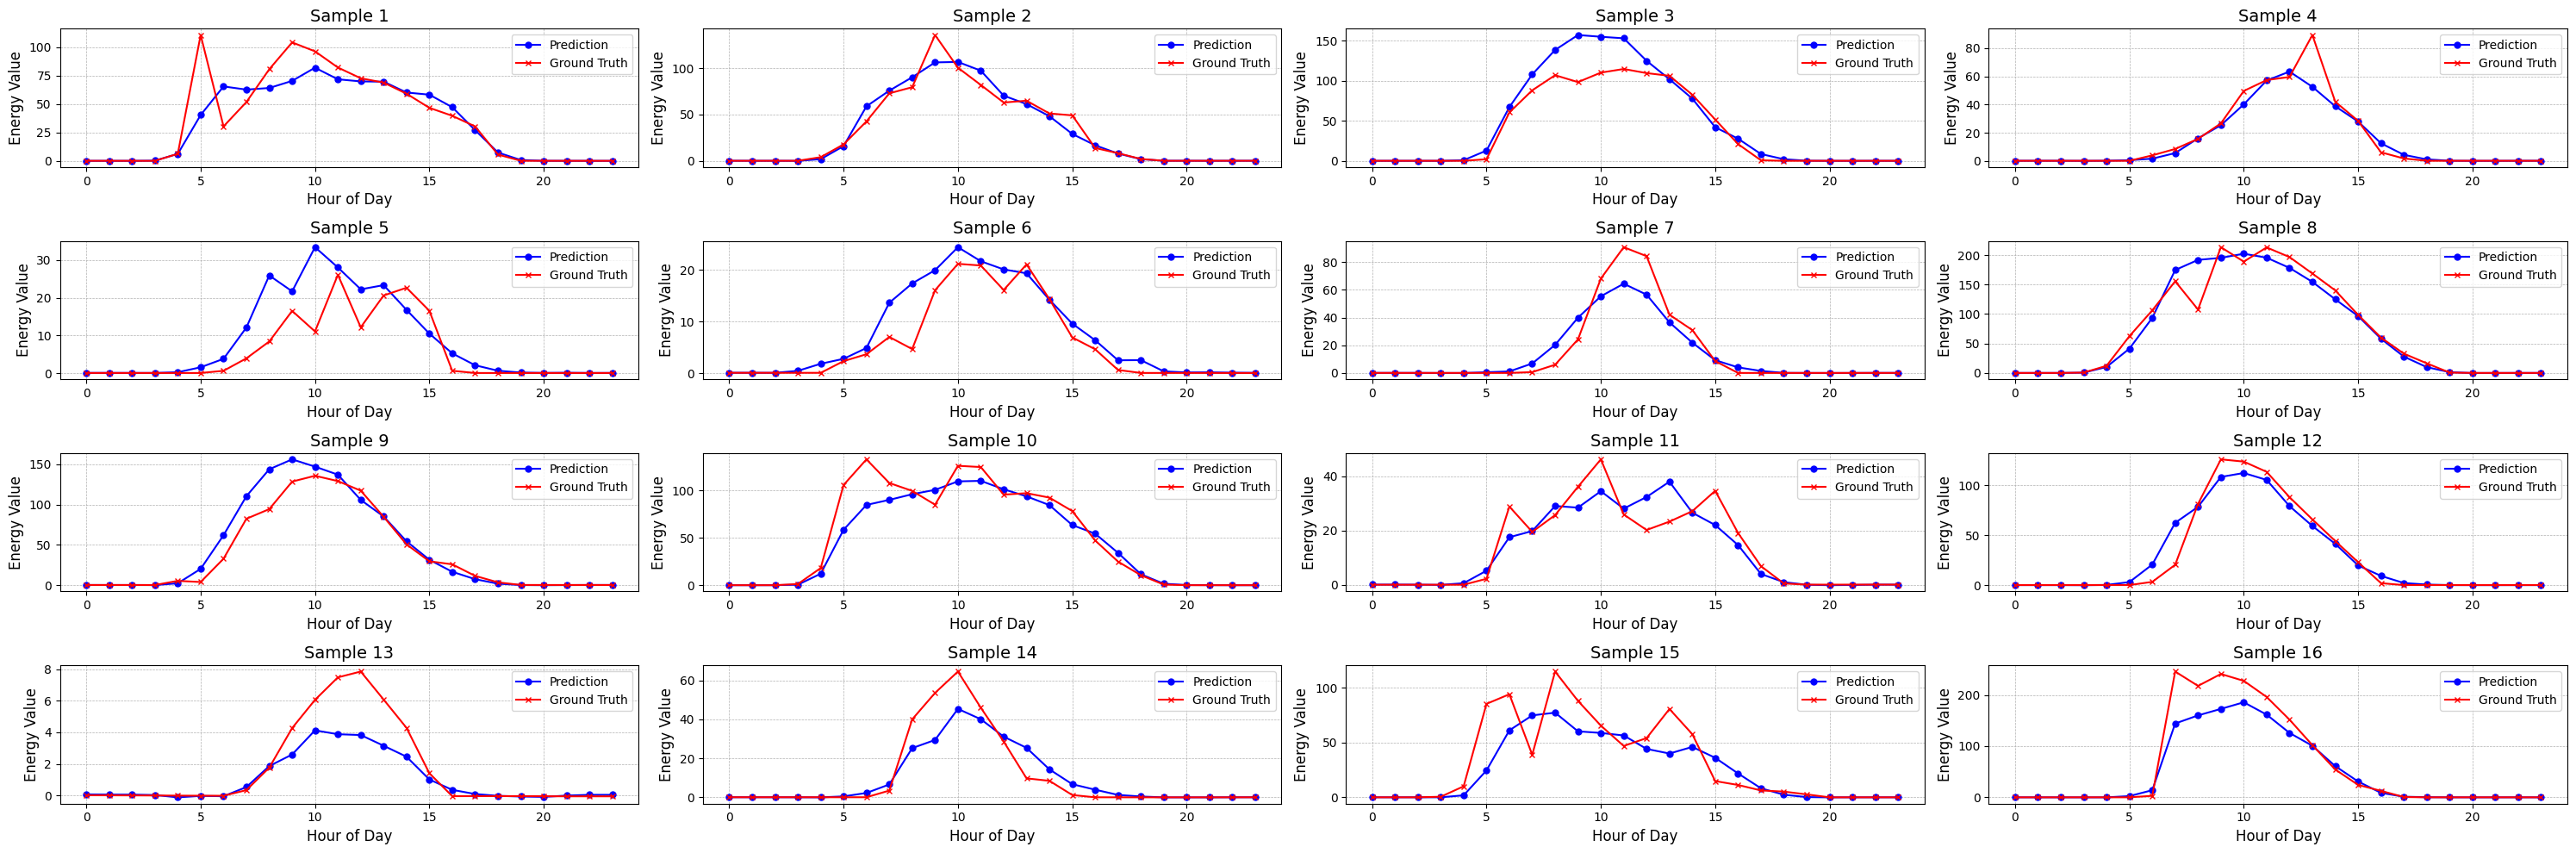

In [ ]:
# Denormalize function using the dataset's method
def denormalize(data, dataset):
    data = data.numpy()
    denormalized_data = data * (dataset.output_maxs - dataset.output_mins) + dataset.output_mins
    return denormalized_data

# Function to plot 24-hour energy data for multiple samples
def plot_energy_data(samples, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(30, 10))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_y = denormalize(predictions[i], dataset)
        gt_y = denormalize(ground_truth[i], dataset)
        
        # Plot energy data
        ax.plot(pred_y, label='Prediction', color='blue', linestyle='-', marker='o', markersize=5)
        ax.plot(gt_y, label='Ground Truth', color='red', linestyle='-', marker='x', markersize=5)
        ax.set_title(f'Sample {i+1}', fontsize=14)
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Energy Value', fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Number of samples to plot and subplots configuration
num_samples = 16
rows = 4
cols = 4

# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(test_synthetic_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = model(samples_dynamic, samples_static)

# Plot the 24-hour energy data for the predicted values and ground truth
plot_energy_data(num_samples, predictions, ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)

In [ ]:
def evaluate_model(model, test_loaders):
    trainer = Trainer(logger=False)
    results = trainer.test(model, dataloaders=test_loaders)
    return results

# Path to the checkpoint
checkpoint_path = "models2/best-model-epoch=04-val_loss=0.06.ckpt"

# Load the best model
checkpoint = torch.load(checkpoint_path)
#print(checkpoint)
print(checkpoint['hyper_parameters'])

model =TrainEnergyPrediction(
        dynamic_feature_size=checkpoint['hyper_parameters']['dynamic_feature_size'],  
        static_feature_size=checkpoint['hyper_parameters']['static_feature_size'],  
        hidden_size=checkpoint['hyper_parameters']['hidden_size'],
        learning_rate=checkpoint['hyper_parameters']['learning_rate'],
        loss_type=checkpoint['hyper_parameters']['loss_type'],
    )
model.load_state_dict(checkpoint['state_dict'])

# Evaluate on both synthetic and measurement test loaders
test_loaders = [test_synthetic_loader, test_measurement_loader]
model_results = evaluate_model(model, test_loaders)

print("Results for the best model:")
print("Synthetic Test Set:", model_results)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


{'dynamic_feature_size': 5, 'static_feature_size': 3, 'hidden_size': 229, 'learning_rate': 7.983338881755285e-05, 'loss_type': 'l1', 'lambda_auc': 3.6450971580991967}


c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([64, 24])) that is different to the input size (torch.Size([64, 24, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (5) must match the size of tensor b (24) at non-singleton dimension 2